In [1]:
import os
from pathlib import Path

cur_path = Path(os.getcwd())
base_dir = cur_path.parent

dataset_path = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
save_dir = os.path.join(base_dir, 'saved_models')

clss = ['0_front', '1_back', '1_front', '2_back', '2_front', '5_front', 'ILU']

train_cls_dirs = [os.path.join(train_dir, c) for c in clss]
test_cls_dirs = [os.path.join(test_dir, c) for c in clss]

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_all_cls_imgs(cls_dirs):
    X = []
    for dir_path in cls_dirs:
        files = sorted(os.listdir(dir_path))
        file_path = os.path.join(dir_path, files[0])
        img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        input_img = img_rgb.astype(np.float32)/255.
        X.append(input_img)

    return np.array(X)

In [3]:
X_train = get_all_cls_imgs(train_cls_dirs)
X_test = get_all_cls_imgs(test_cls_dirs)

In [4]:
import tensorflow as tf
from tensorflow.keras import models

model = models.load_model(os.path.join(save_dir, "hand_sign_2.h5"))
layer_outputs = [layer.output for layer in model.layers if "conv2d" in layer.name]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 170, 130, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 168, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 168, 128, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 168, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 166, 126, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 166, 126, 16)      64        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 166, 126, 16)      0     

In [5]:
img_tensor = np.expand_dims(X_train[0], axis=0)
activations = activation_model.predict(img_tensor)

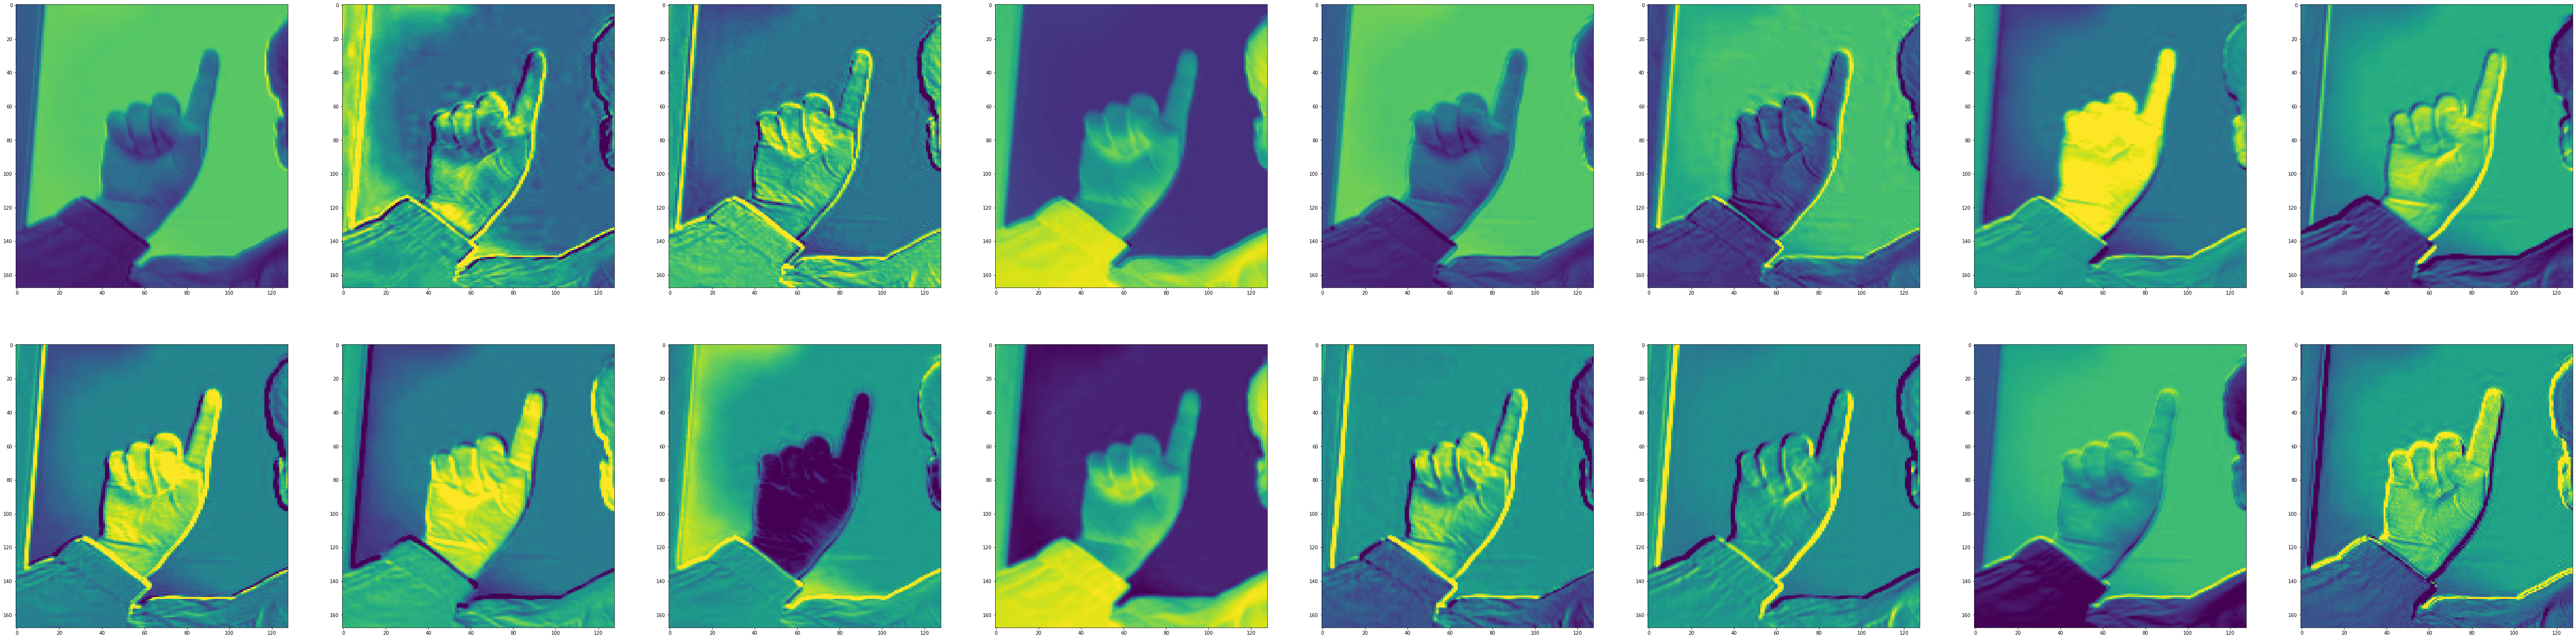

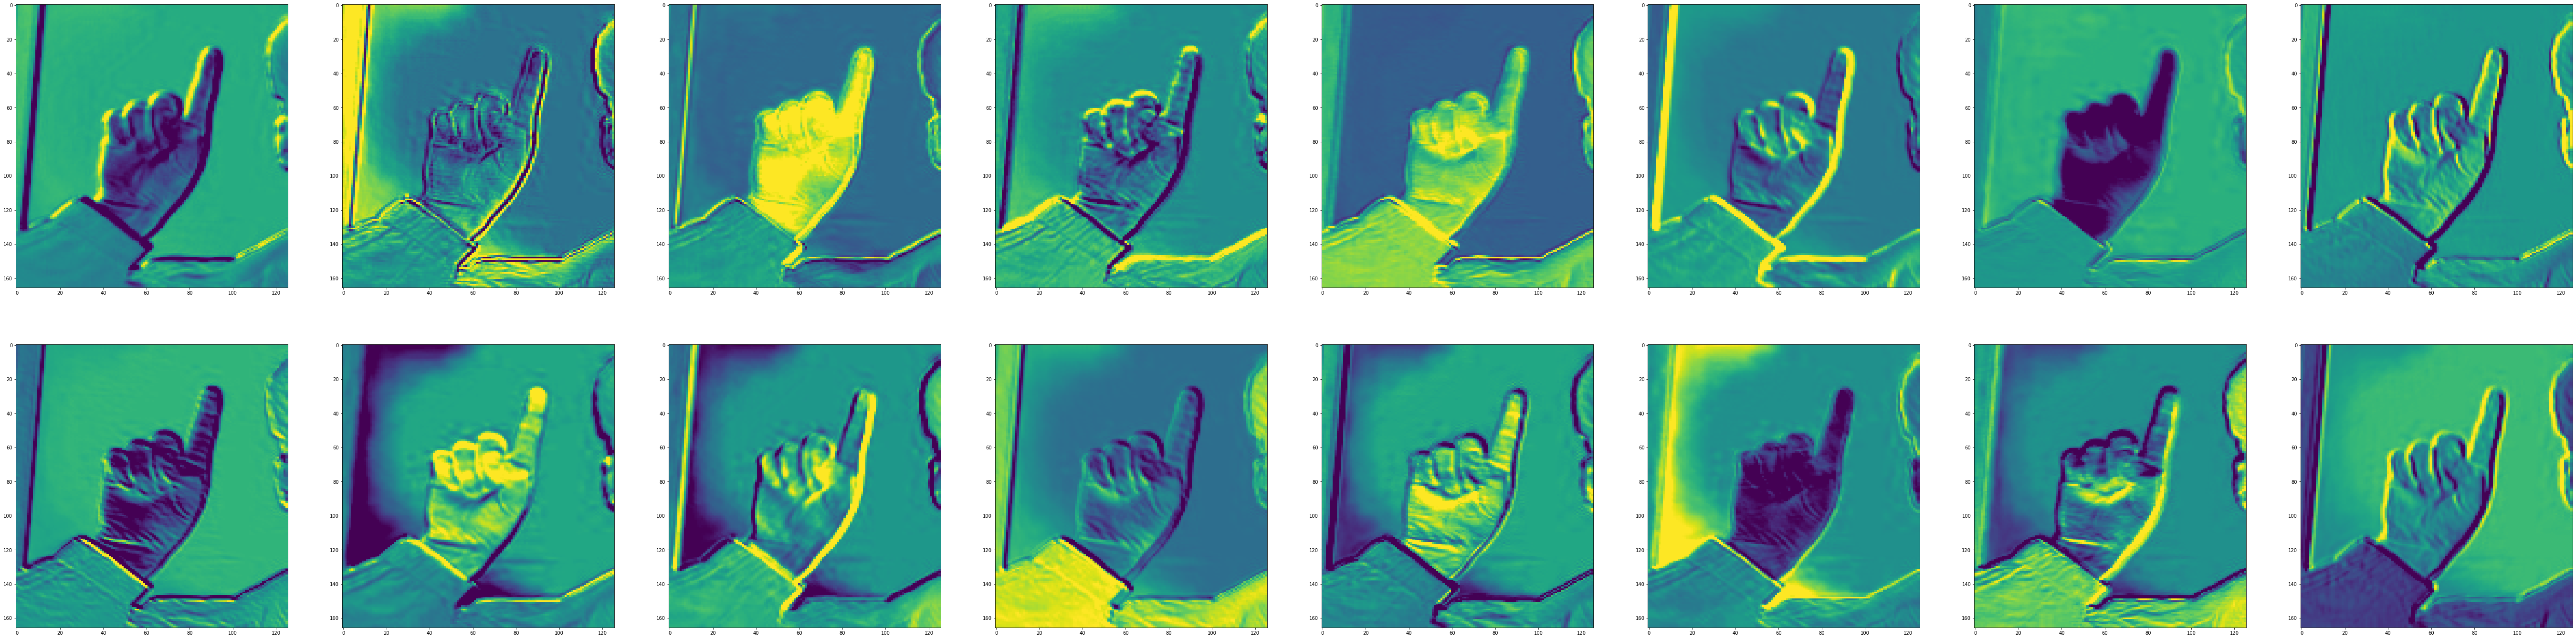

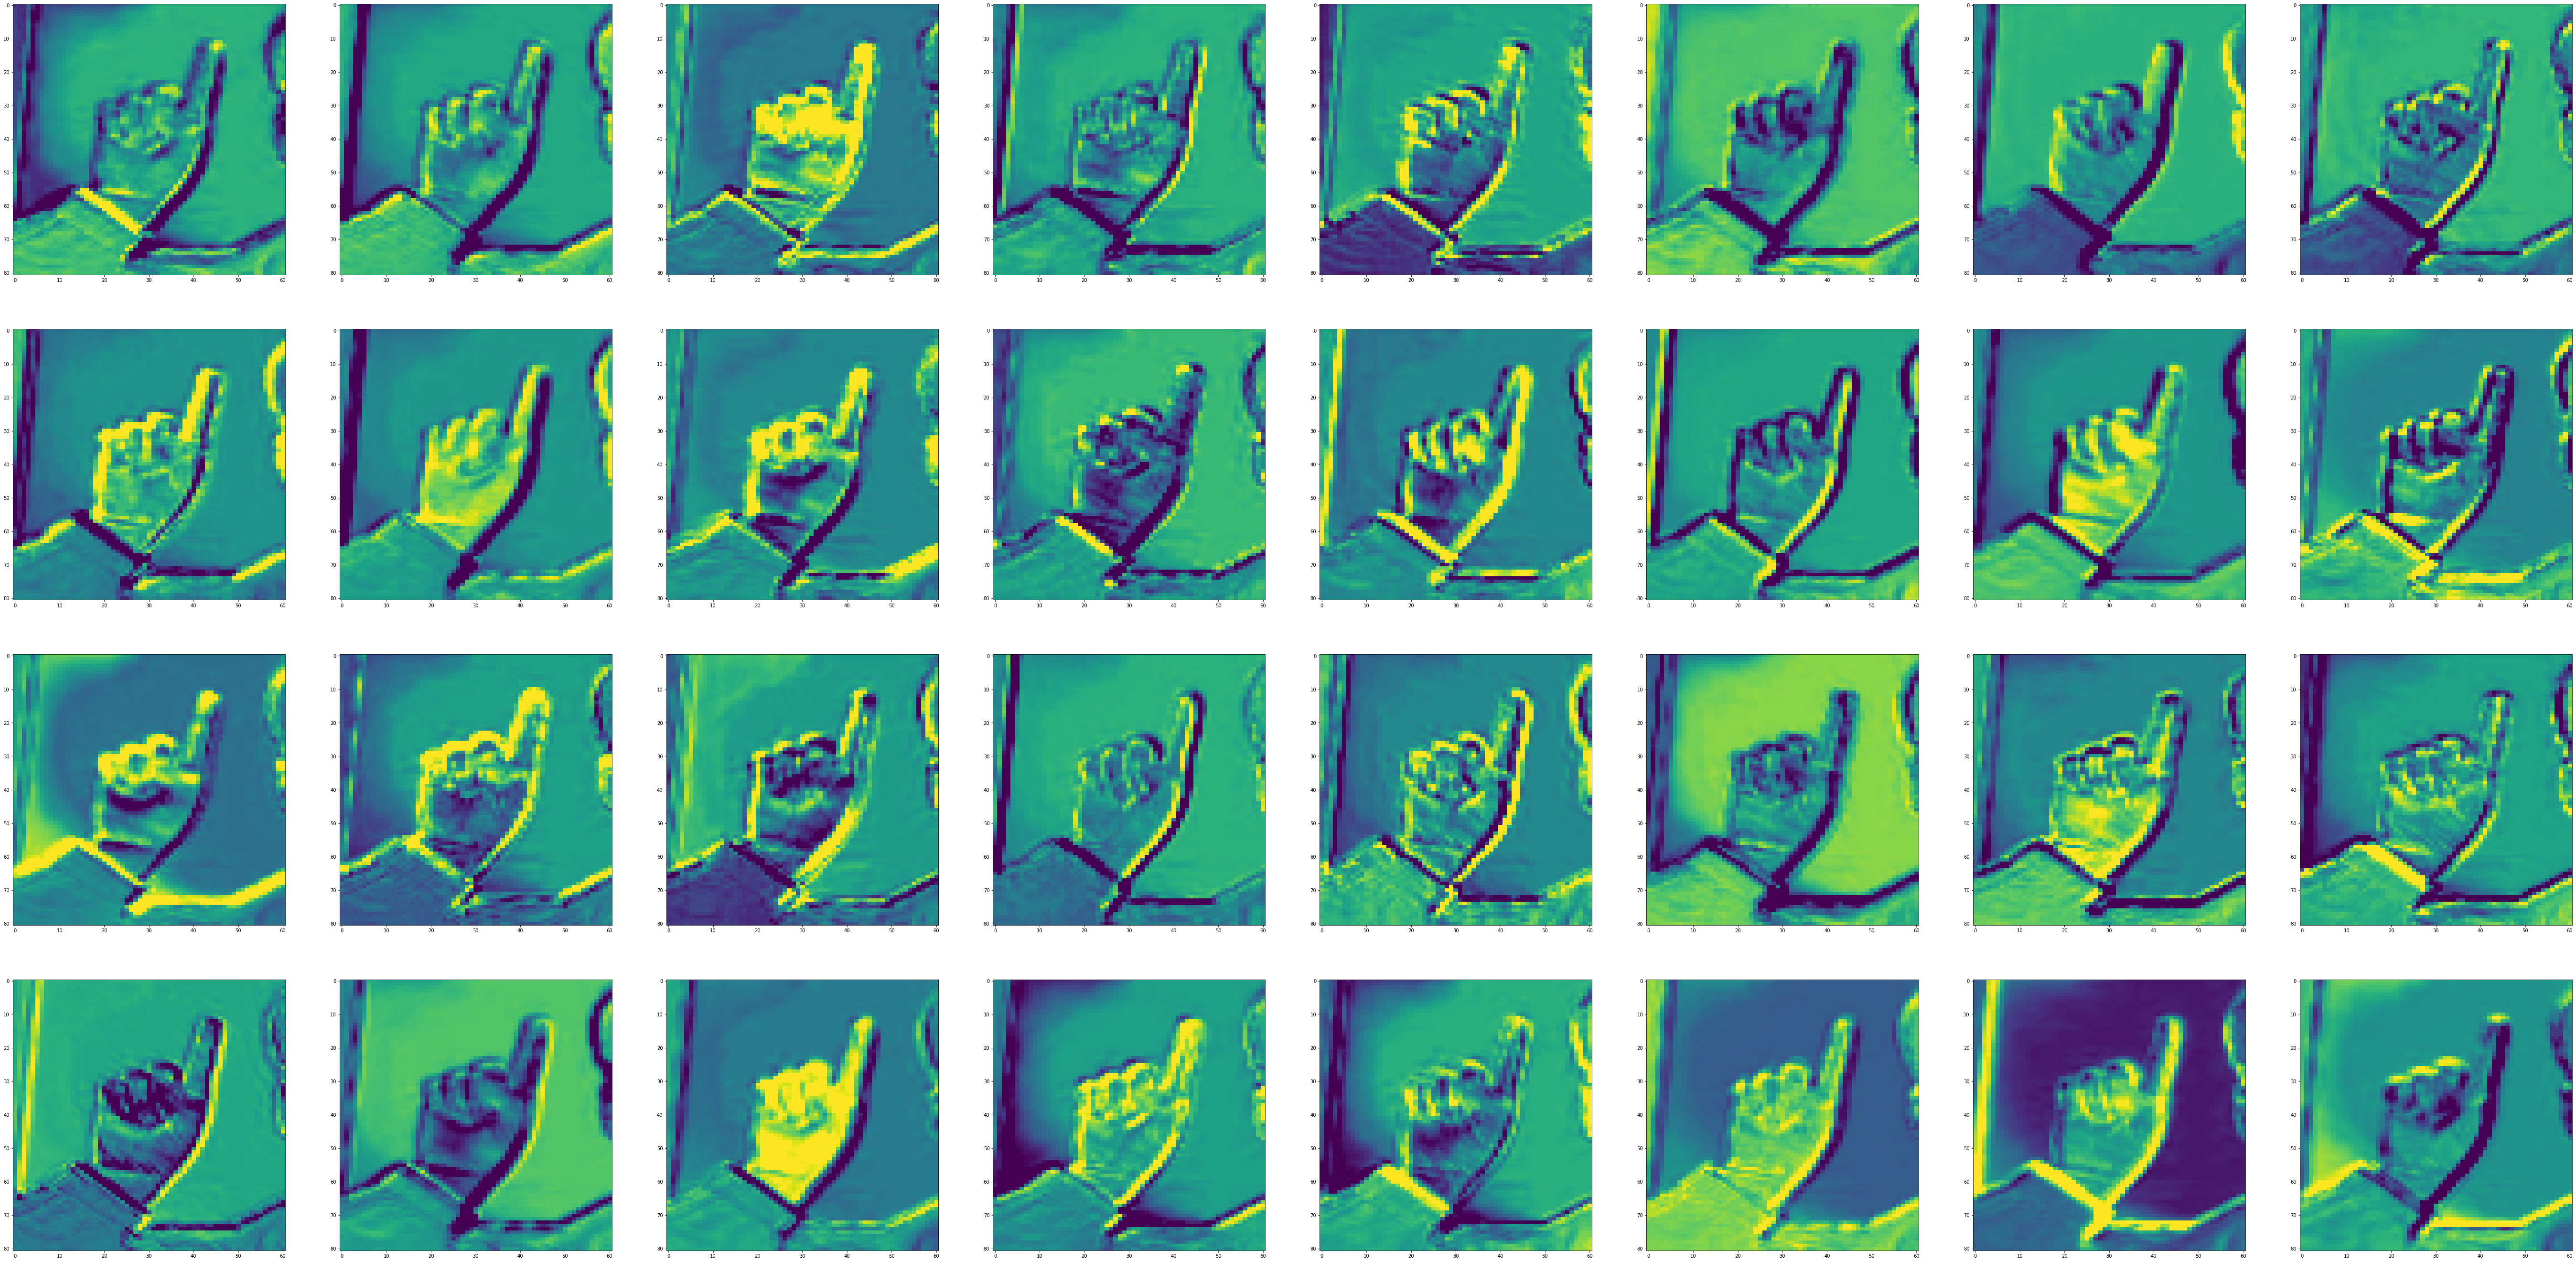

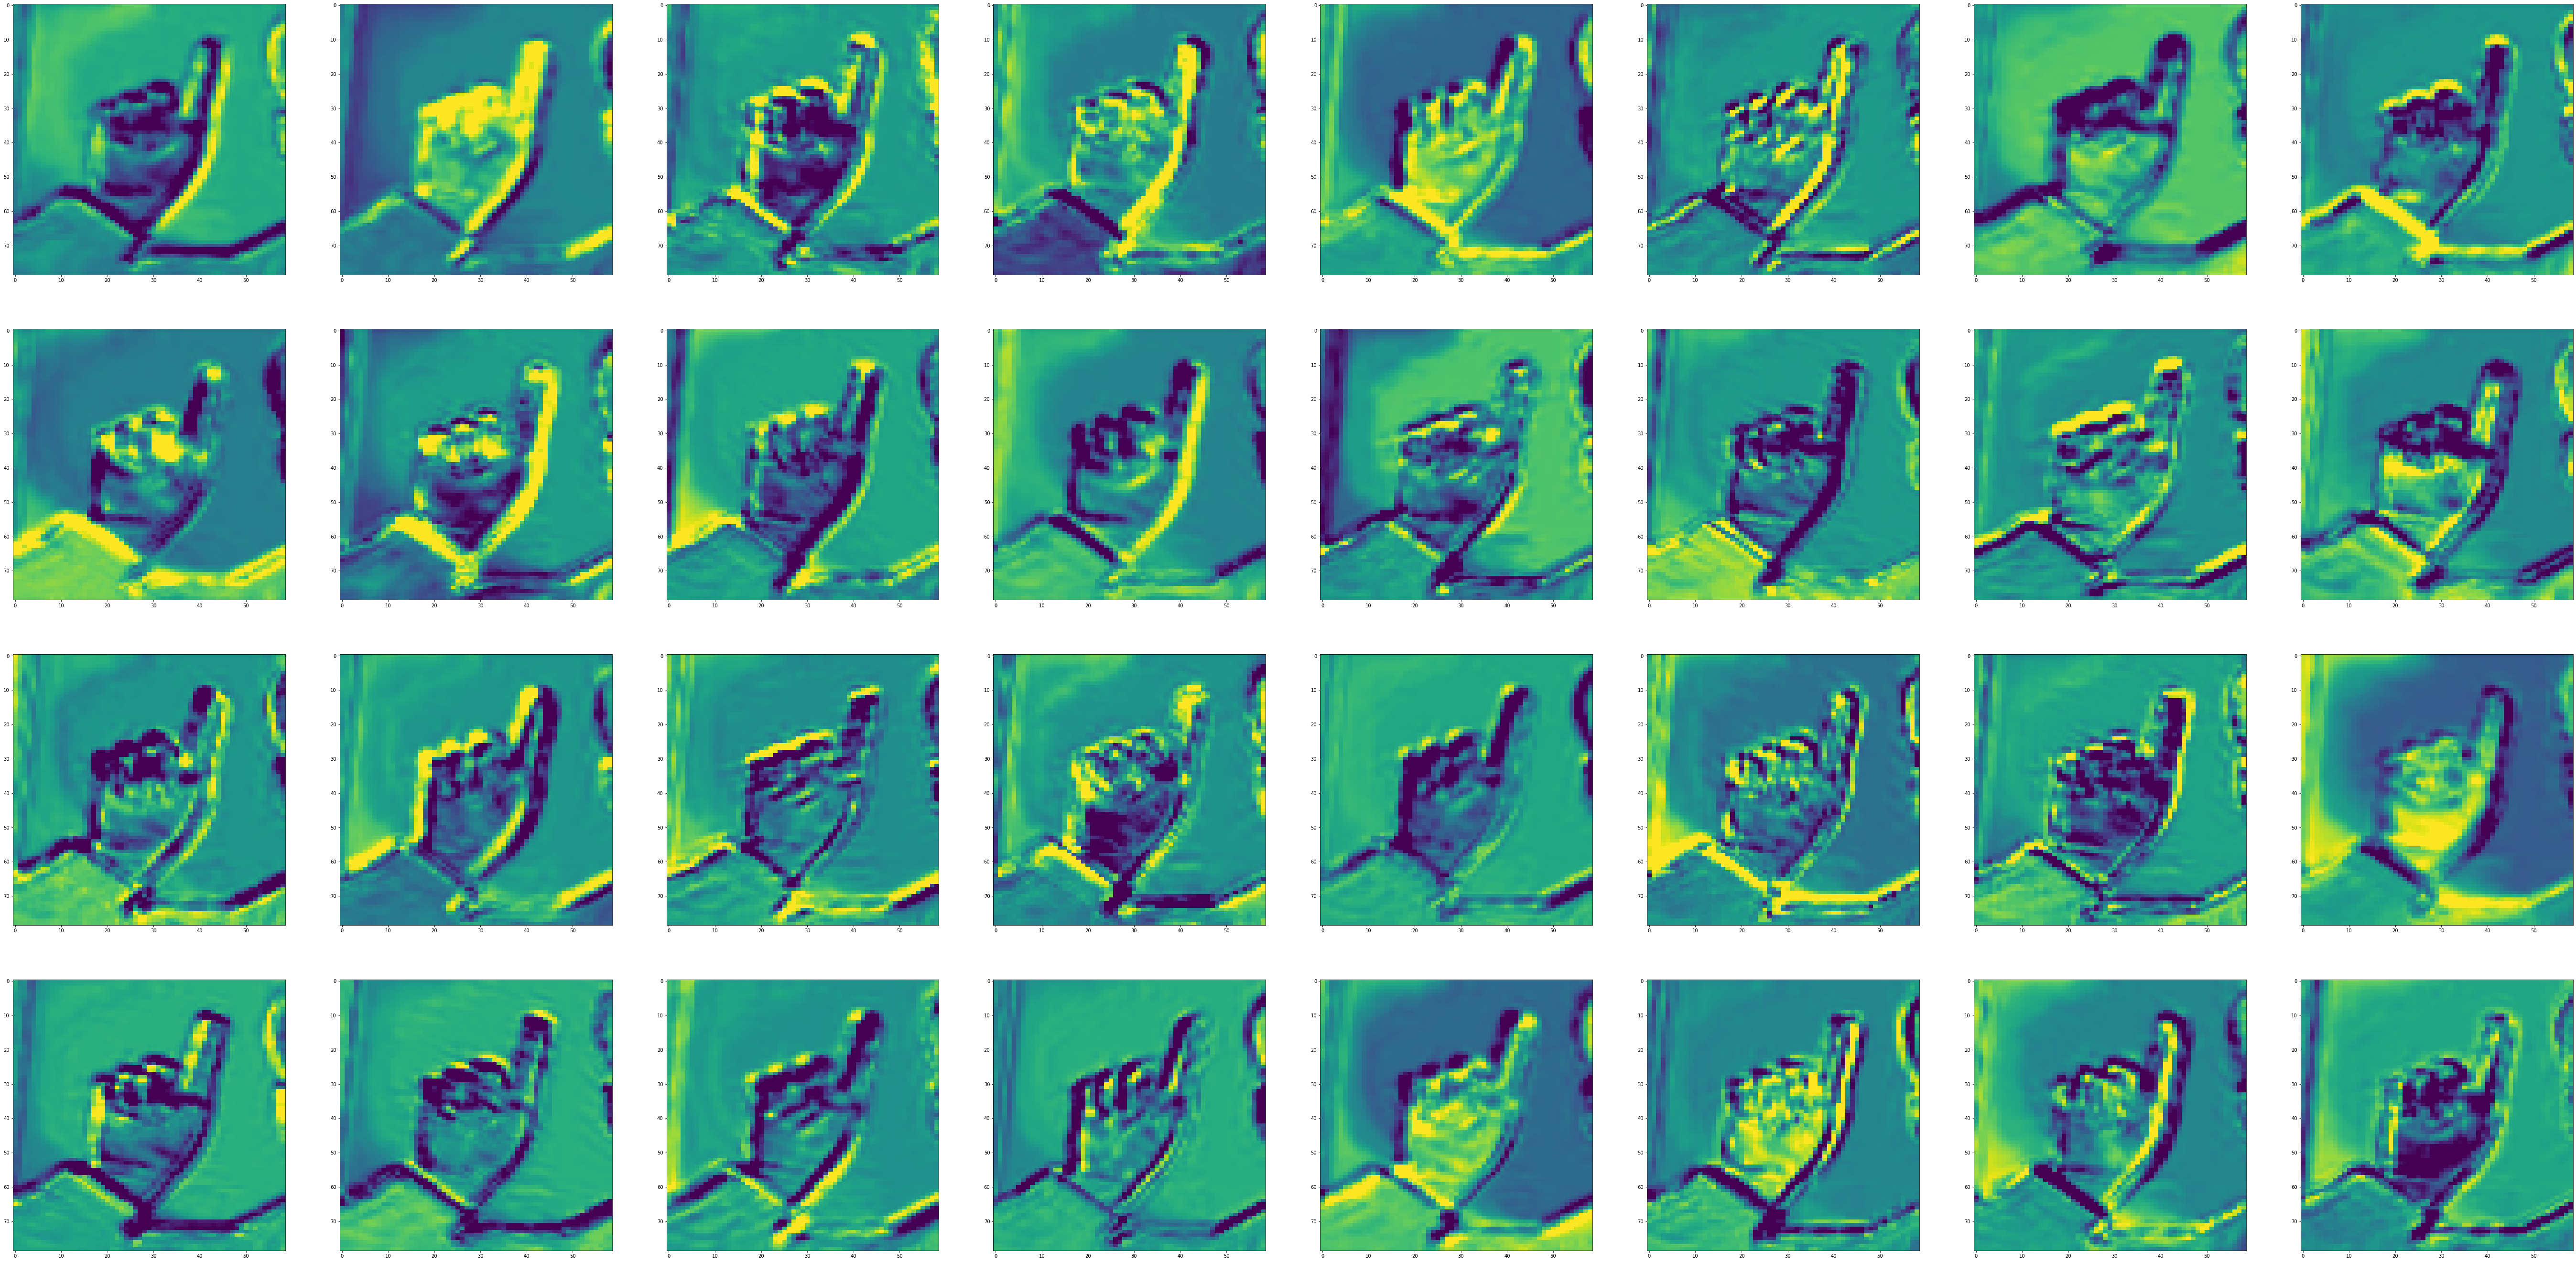

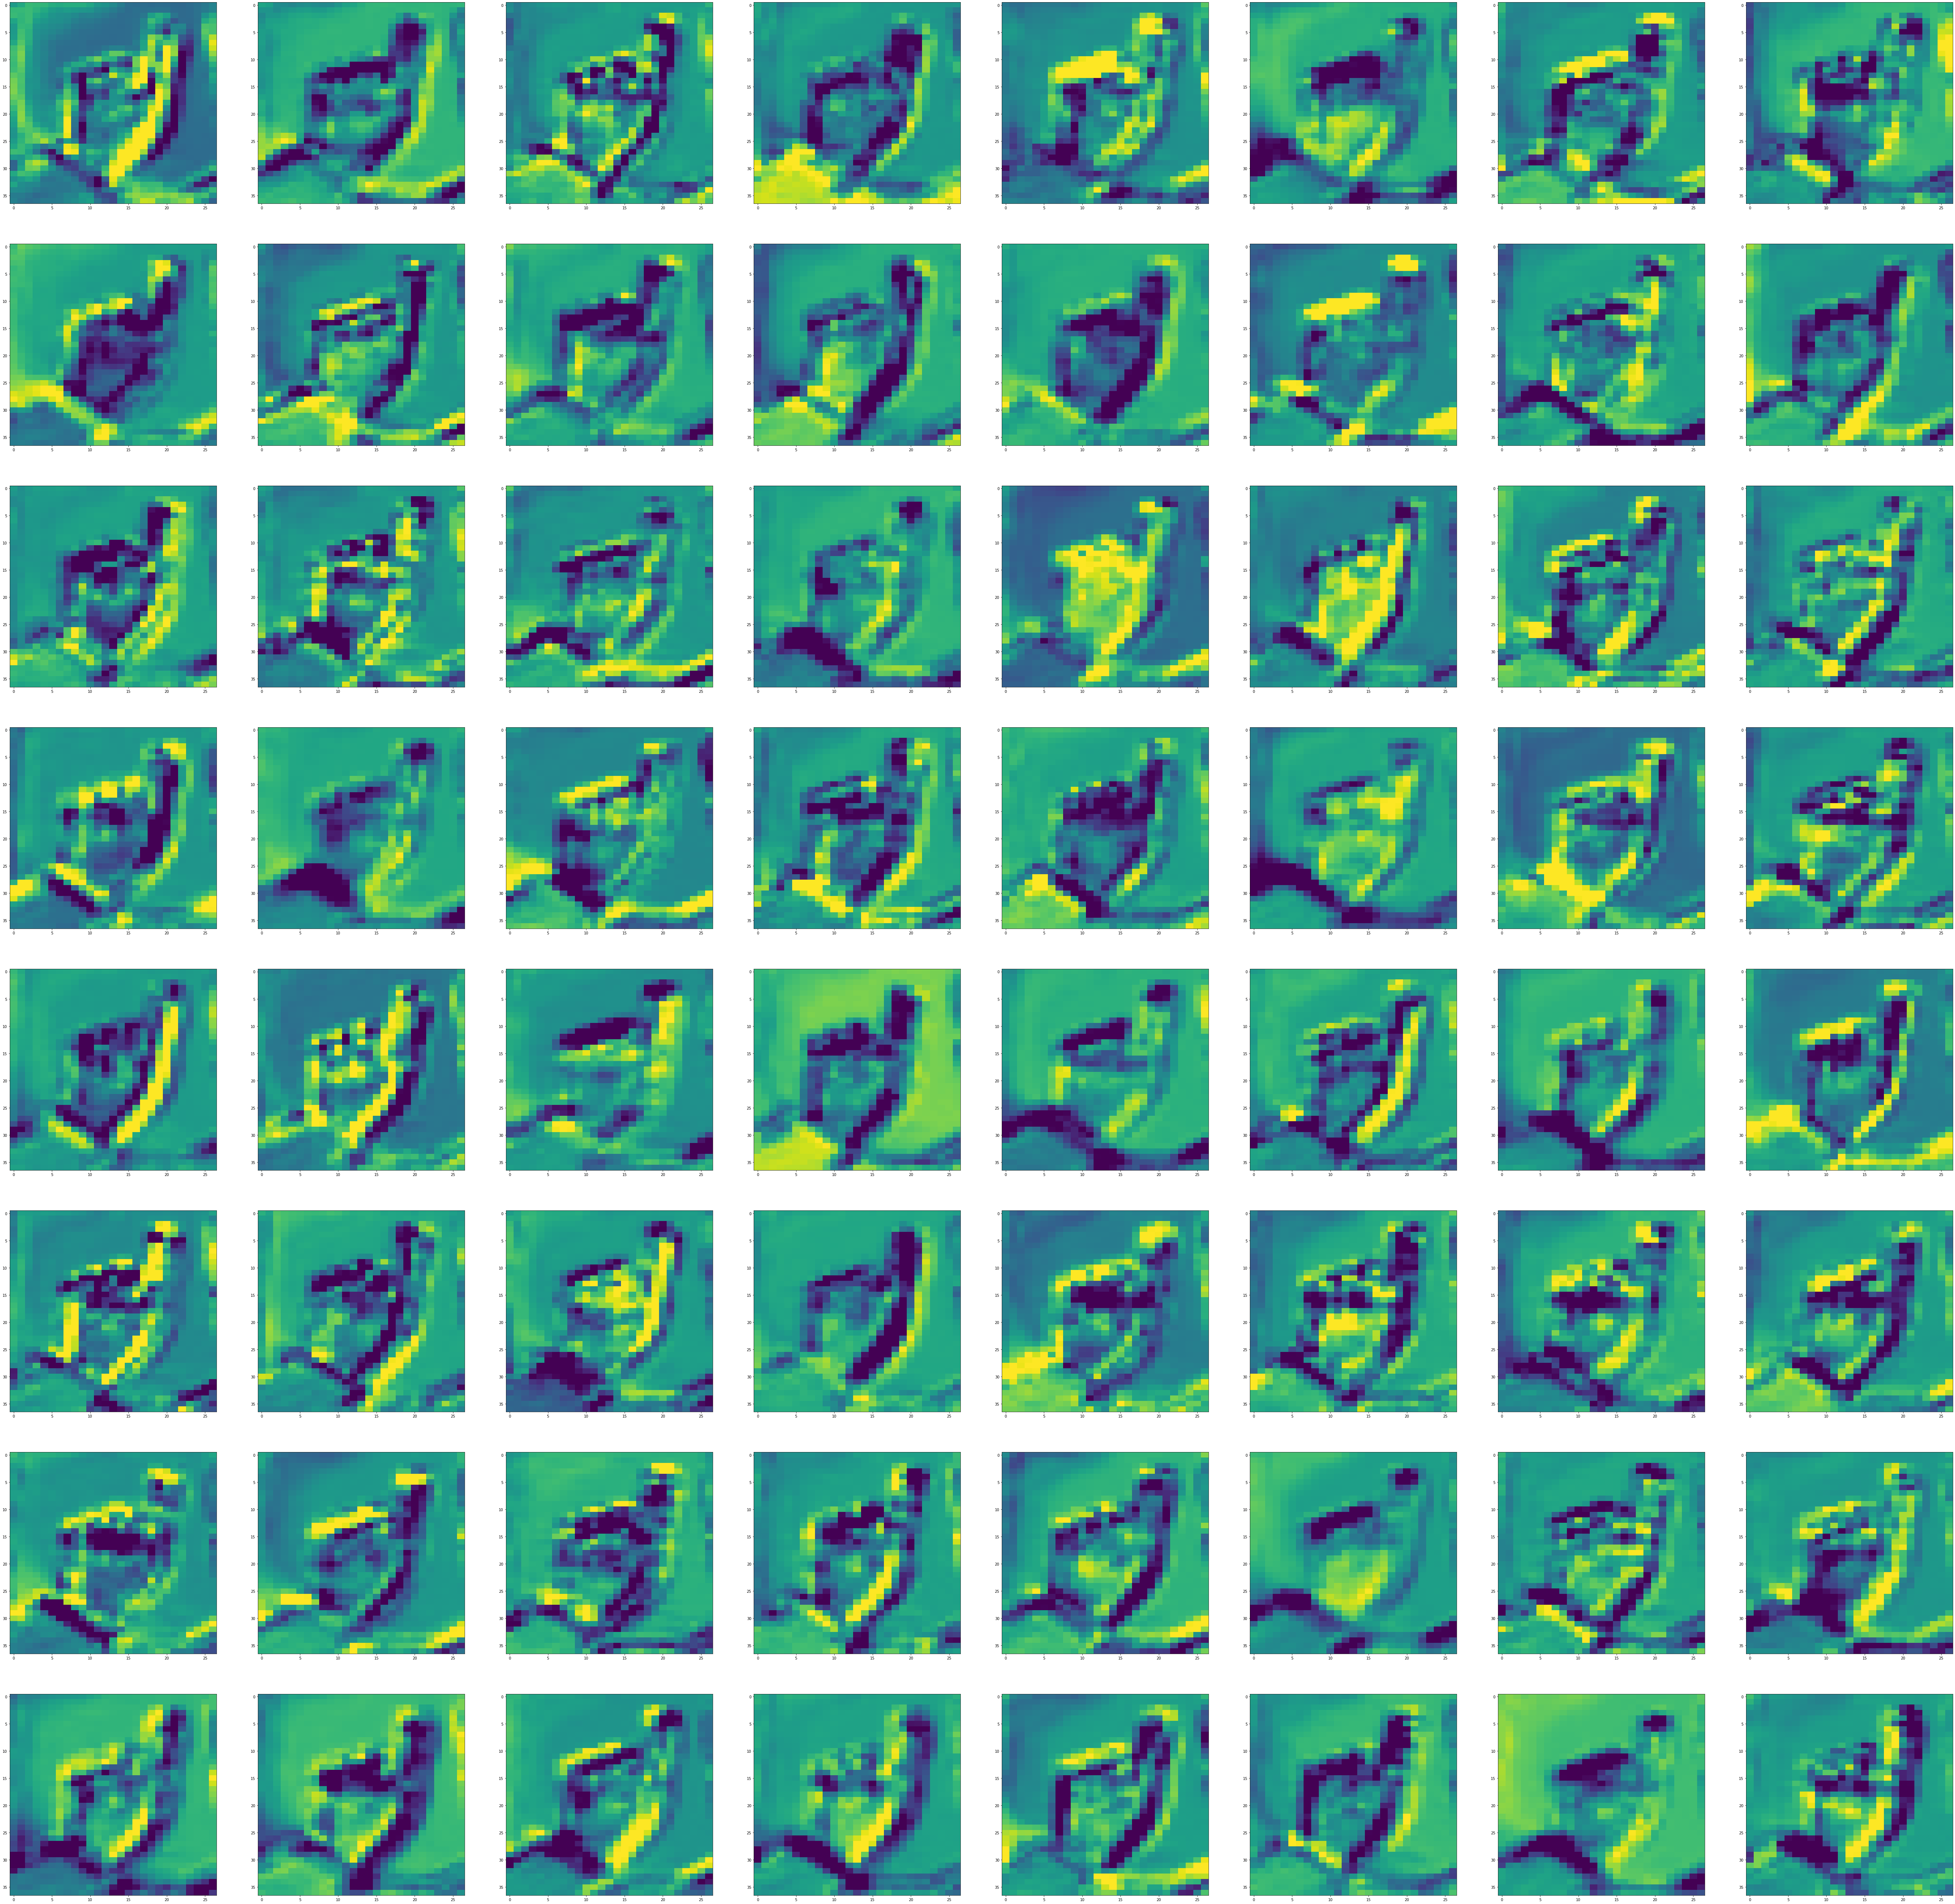

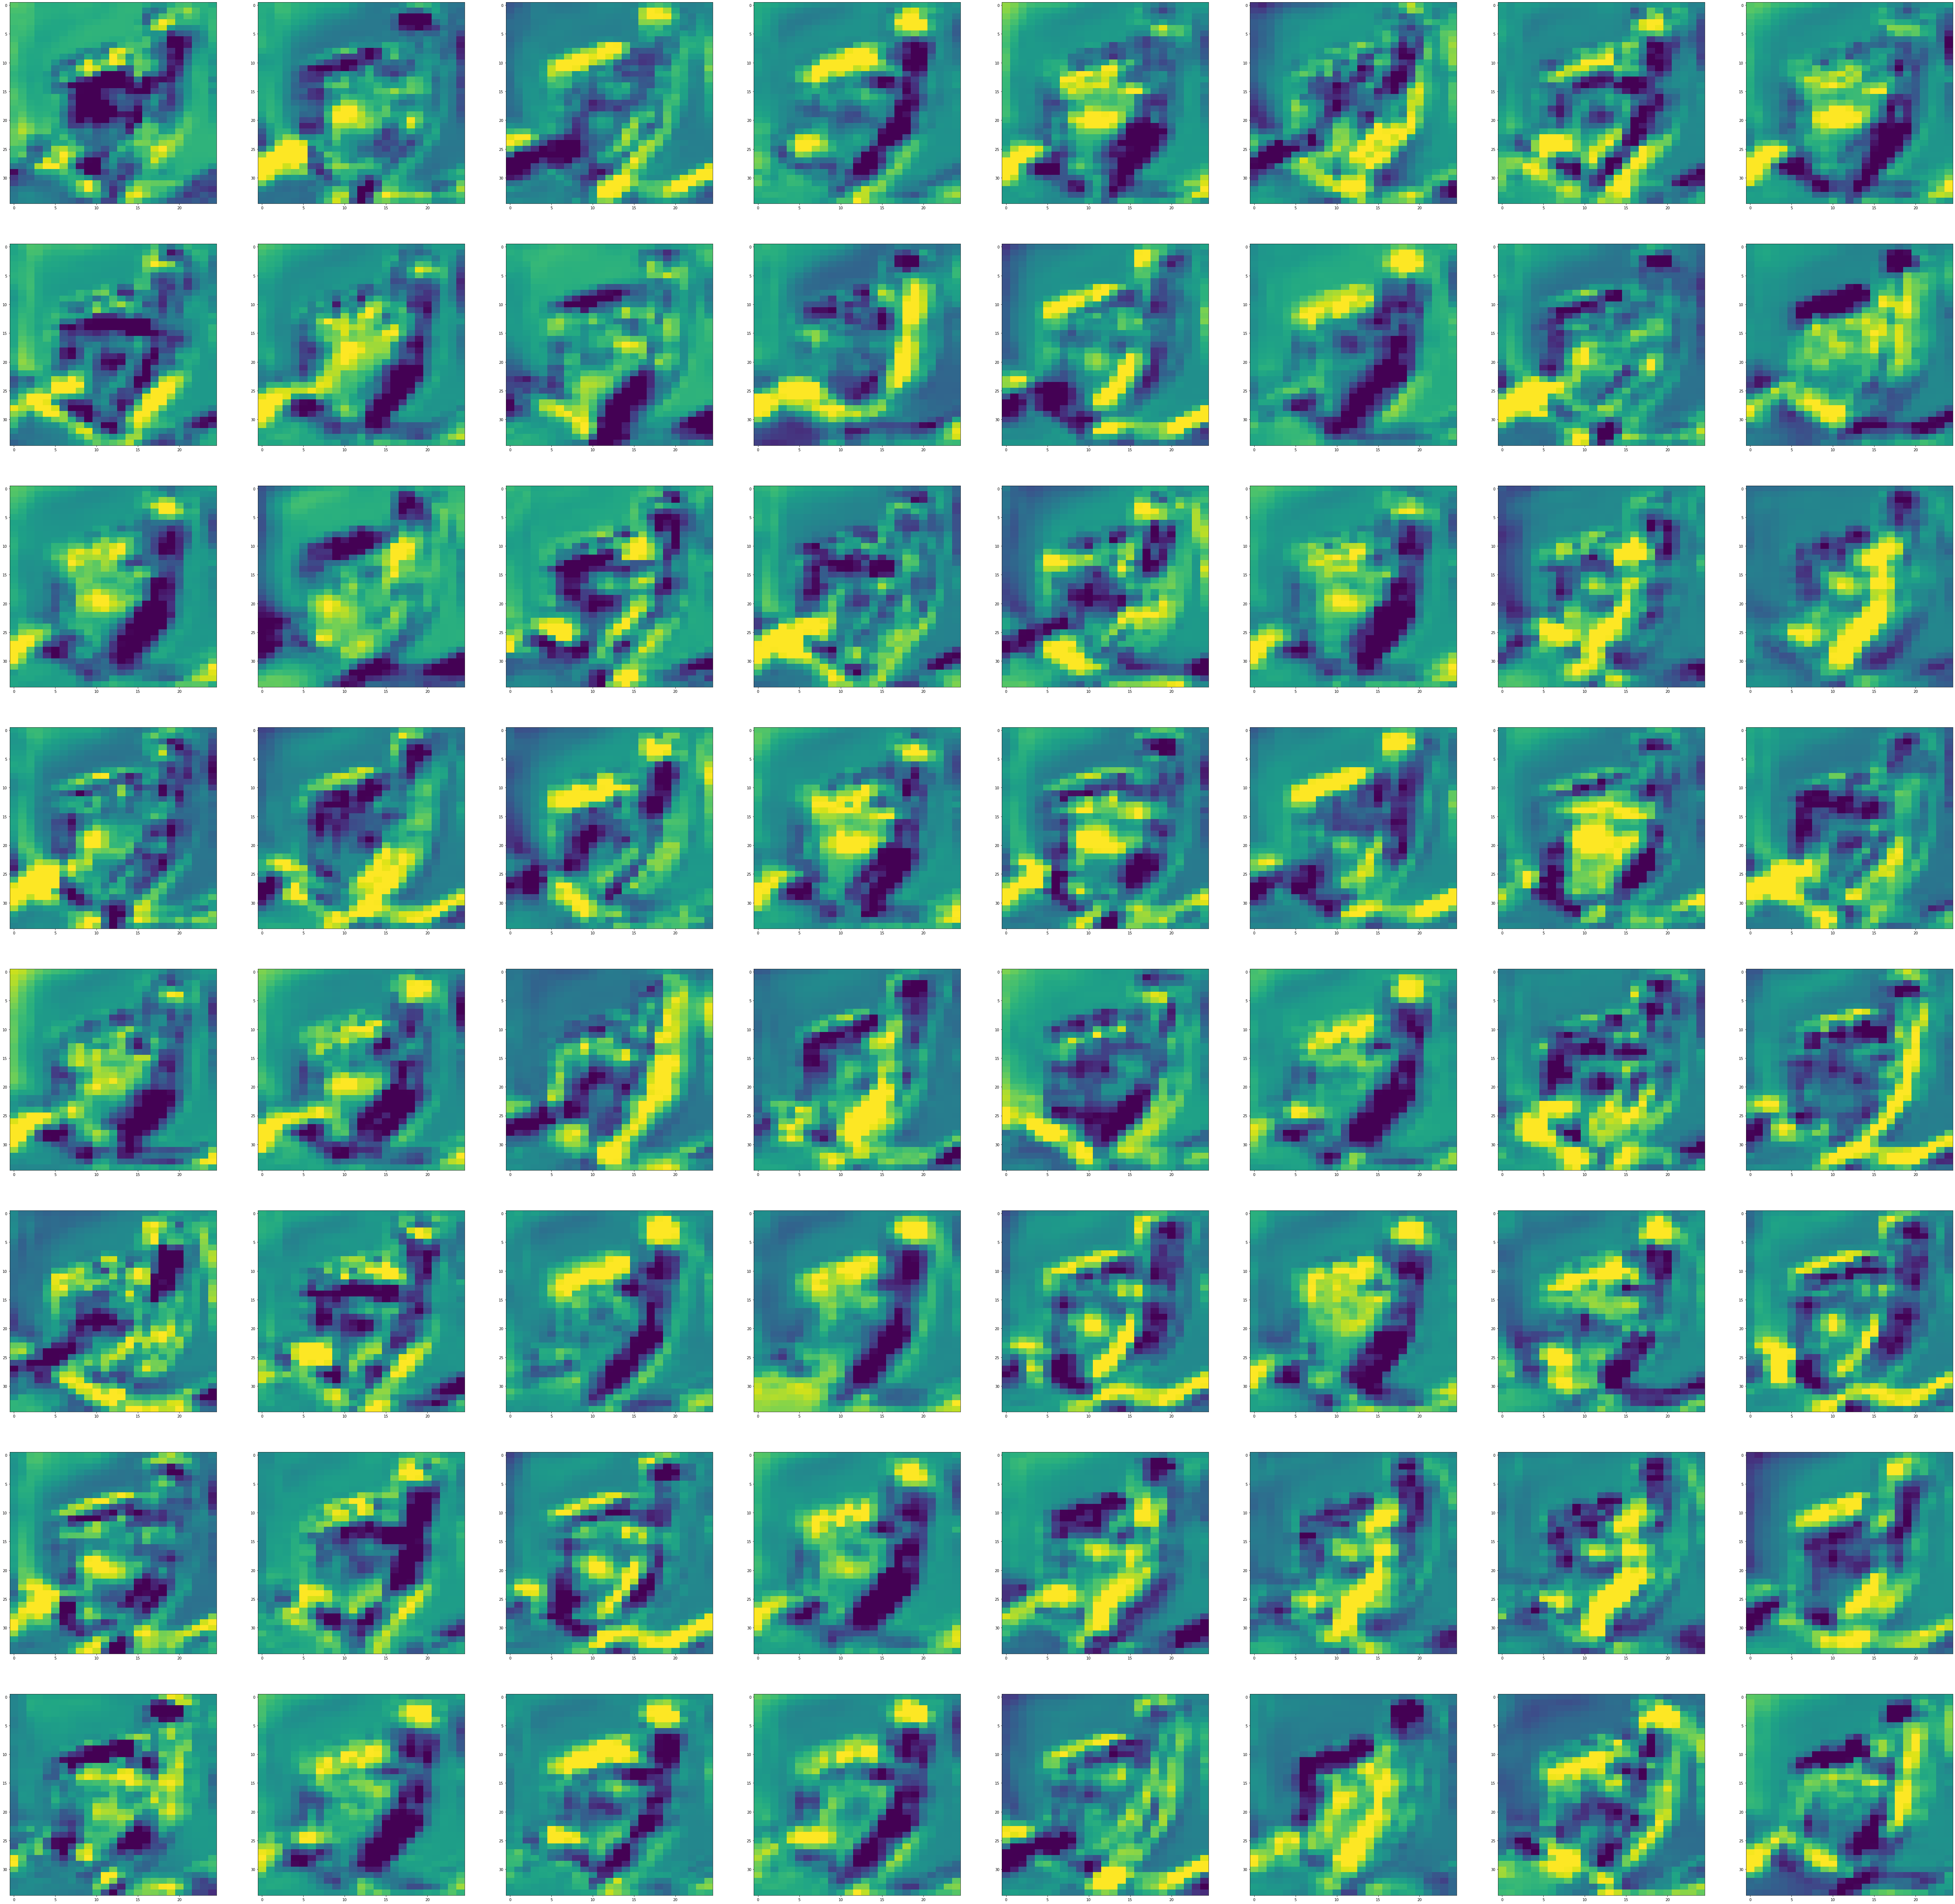

In [26]:
img_tensor = np.expand_dims(X_test[2], axis=0)
activations = activation_model.predict(img_tensor)

cols = 8

for activation in activations:
    n_channels = activation.shape[-1] # number of channels 
    w_channel = activation.shape[1]   # channel's width
    h_channel = activation.shape[2]   # channel's height
    
    rows = n_channels // cols
    fig = plt.figure(figsize=(12*cols, 12*rows))
    
    for row in range(rows):
        for col in range(cols):
            ax = fig.add_subplot(rows, cols, col+(cols*row)+1)
            channel = activation[0, :, :, col+(cols*row)]
            
            # z-score
            channel_mean = channel.mean()
            channel_std = channel.std()
            channel -= channel_mean
            channel /= channel_std
            
            # 오른쪽으로 2만큼 이동 후 64 곱해서 0~255로 증폭
            channel += 2
            channel *= 64
            
            # 0~255로 cliping
            channel = np.clip(channel, 0, 255).astype('uint8')
            ax.imshow(channel, aspect='auto', cmap='viridis')

plt.show()